In [1]:
import numpy as np
import matplotlib.pyplot as plt
import concurrent.futures
import threading
import time
from timeit import default_timer as timer
from typing import Callable
plt.rcParams['figure.figsize']=(20, 10)

# Statystyka - Zestaw 3
### Autor: Konrad Ulman

### Symulacja procesu kolejkowego

* Zadania przychodzą w tępie $ \lambda_A $
* Serwer obsługuje zadania w tępie $ \lambda_S $

In [2]:
lock = threading.Lock()
queue_pos = 0

class Task:
    def __init__(self, id, start_queue, start, end_queue = None, end = None):
        self.id = id
        self.start_queue = start_queue
        self.end_queue = end_queue
        self.start = start
        self.end = end
        
    def recalculate_time(self, time):
        self.start = self.start - time
        self.end = self.end - time
        return self
    
    def __str__(self):
        return f'Task id is {self.id}'

    def __repr__(self):
        return str(self.__dict__)
    
def producer(task_size: int, delay: float) -> list:
    global queue_pos
    
    for id in np.arange(task_size):
        time.sleep(delay)
        with lock:
            q_pos = queue_pos
            queue_pos += 1
        
        yield Task(id, q_pos, timer())
    
def consume(delay: float, task: Task) -> Task:
    global queue_pos
    
    time.sleep(delay)
    with lock:
        queue_pos -= 1
        task.end_queue = queue_pos
    
    task.end = timer()
    return task
    
def consumer(delay: float, func: Callable, *args) -> list:
    start = timer()
    with concurrent.futures.ThreadPoolExecutor(max_workers=1) as executor:
        producer_logs = []
        futures = []
        done_tasks = []
        for task in func(*args):
            futures.append(executor.submit(consume, delay, task))
            
        recalculate = lambda r: r.recalculate_time(start)
        return sorted([recalculate(future.result()) for future in concurrent.futures.as_completed(futures)], key=lambda x: x.id)

In [3]:
def extract_queues(tasks: list) -> list:
    start_queue = []
    end_queue = []
    for task in tasks:
        start_queue.append(task.start_queue)
        end_queue.append(task.end_queue)
    return start_queue, end_queue

def extract_points(tasks: list) -> list:
    start = []
    end = []
    for task in tasks:
        start.append(task.start)
        end.append(task.end)
    return start, end

In [4]:
def plot_points(tasks: list) -> None:
    start_queue, end_queue = extract_queues(tasks)
    start_times, end_times = extract_points(tasks)
    
    plt.scatter(start_times, start_queue, color='r', label='$\pi_j$')
    plt.scatter(end_times, end_queue, color='b', label='$\pi_j$')

    for i, e in enumerate(tasks):
        plt.text(start_times[i], start_queue[i] * (1 + 0.1), f'id: {e.id}', fontsize=12)
        plt.text(end_times[i], end_queue[i] * (1 - 0.1), f'id: {e.id}', fontsize=12)

    plt.xlabel('Czas', fontsize=20)
    plt.ylabel('Kolejka', fontsize=20)
    plt.ylim(0, max(max(start_queue) + 1, 1))
    plt.grid()
    plt.show()

In [5]:
def calc_wait_time(tasks: list) -> list:
    return [task.end - task.start for task in tasks]

def plot_wait(tasks: list) -> None:
    wait_time = calc_wait_time(tasks)
    plt.plot([task.start for task in tasks], wait_time, color='r', label='$\pi_j$')
    plt.xlabel('Czas', fontsize=20)
    plt.ylabel('Czas oczekiwania', fontsize=20)
    plt.grid()
    plt.ylim(0, max(wait_time) + 1)
    plt.show()

### $ \lambda_A $: zadania napływają co $ \dfrac{1}{15}[s] $
### $ \lambda_S $: czas potrzebny na wykonanie zadania $ \dfrac{1}{20}[s] $

#### $ \lambda_S < \lambda_A $ - zadania wykonywane szybciej niż przychodzą

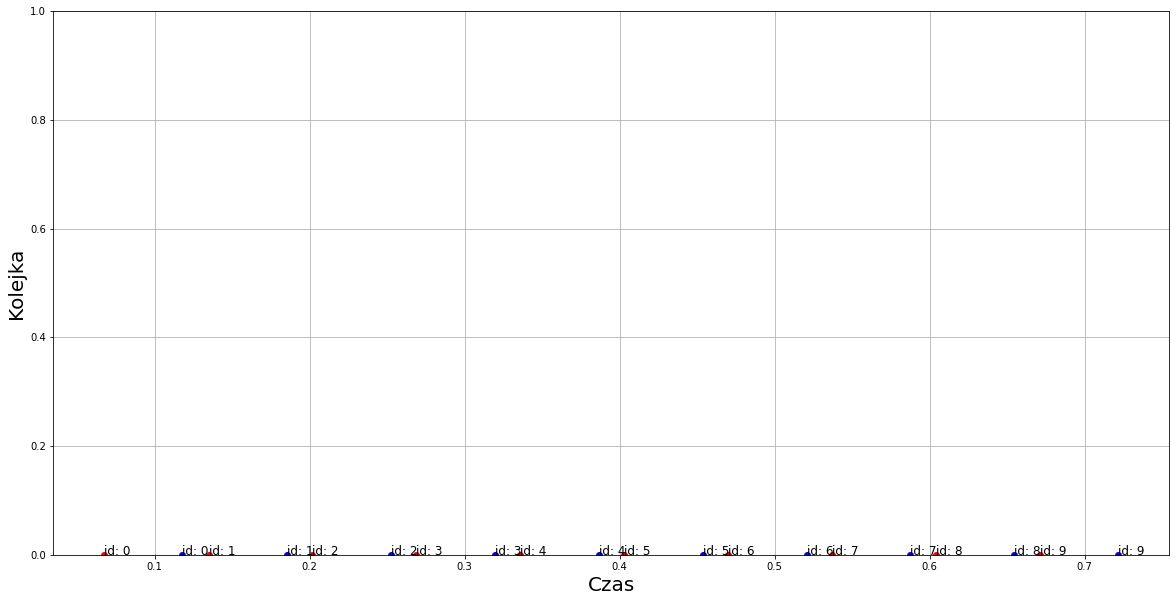

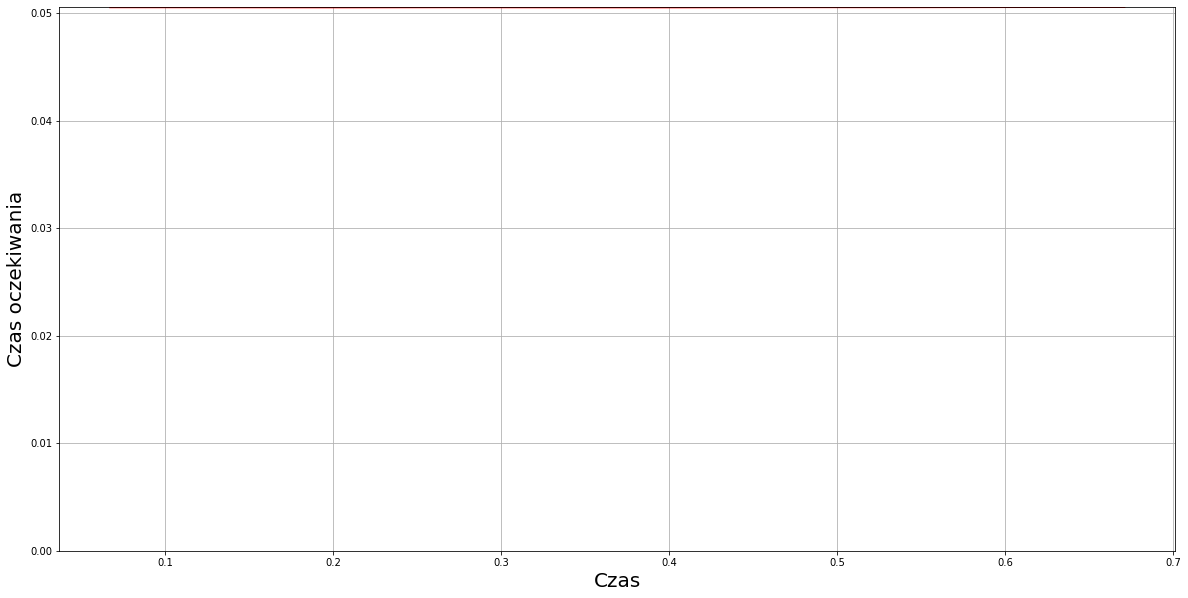

In [6]:
producer_delay = 1/15
consumer_delay = 1/20
num_of_tasks = 10

tasks = consumer(consumer_delay, producer, num_of_tasks, producer_delay)

plot_points(tasks)
plot_wait(tasks)

### $ \lambda_A $: zadania napływają co $ \dfrac{1}{10}[s] $
### $ \lambda_S $: czas potrzebny na wykonanie zadania $ \dfrac{1}{2}[s] $

#### $ \lambda_S > \lambda_A $ - zadania przychodzą znacznie szybciej niż są wykonywane

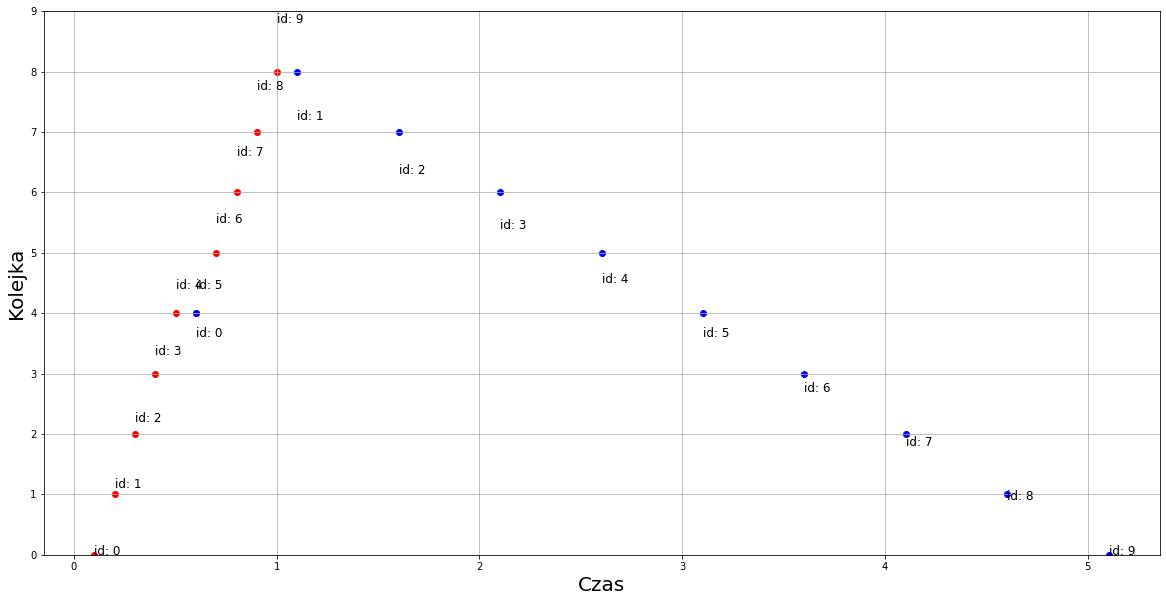

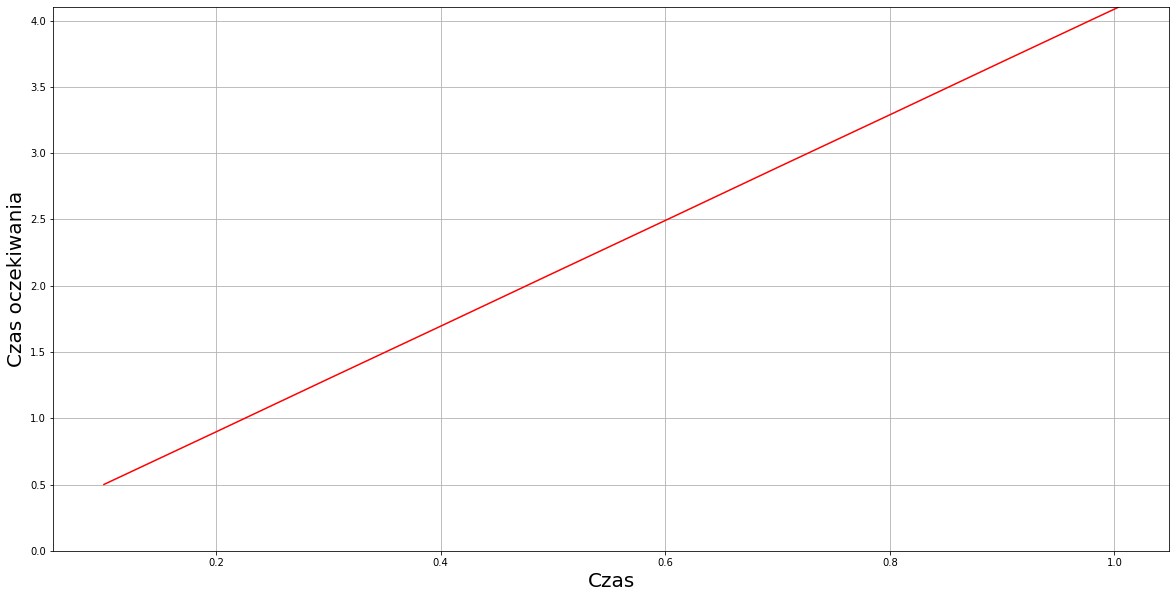

In [7]:
producer_delay = 1/10
consumer_delay = 1/2
num_of_tasks = 10

tasks = consumer(consumer_delay, producer, num_of_tasks, producer_delay)

plot_points(tasks)
plot_wait(tasks)

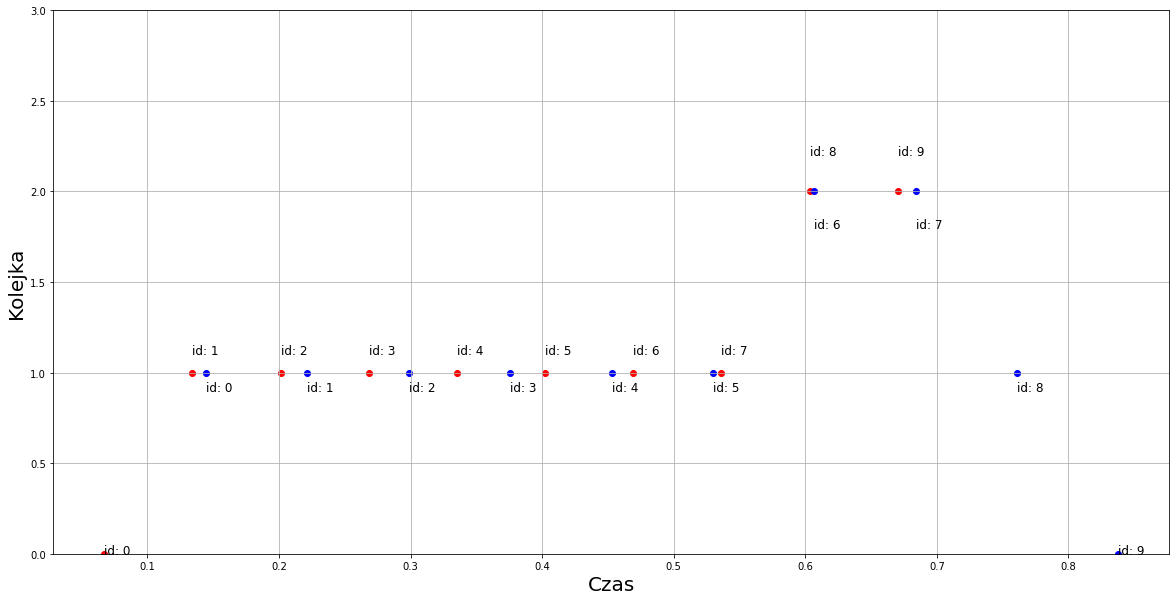

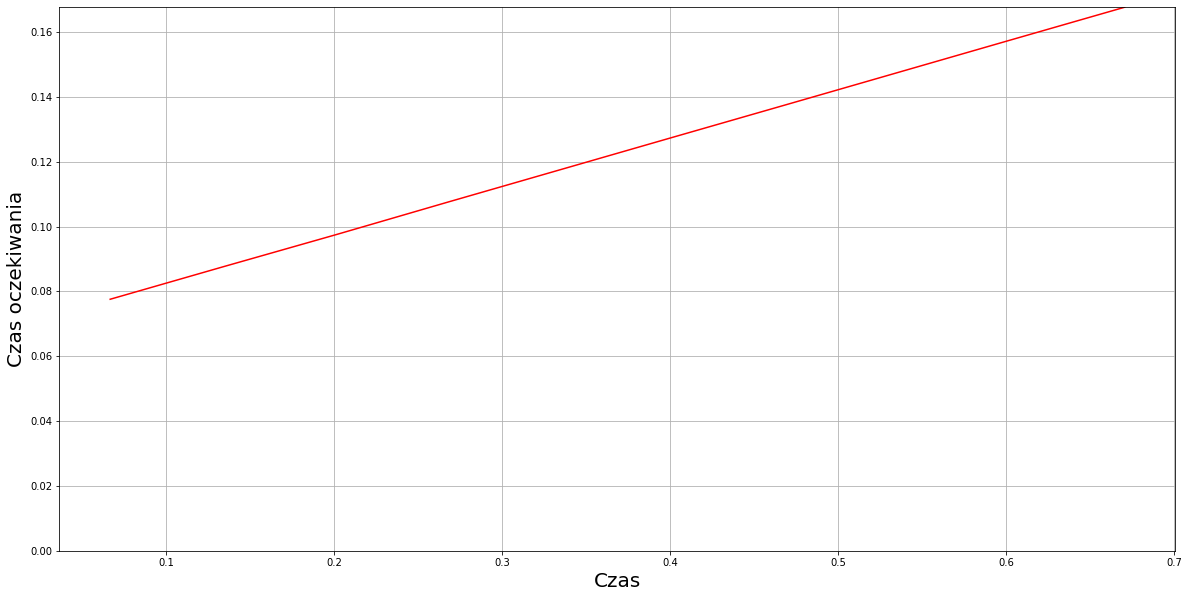

In [8]:
producer_delay = 1/15
consumer_delay = 1/13
num_of_tasks = 10

tasks = consumer(consumer_delay, producer, num_of_tasks, producer_delay)

plot_points(tasks)
plot_wait(tasks)